<a href="https://colab.research.google.com/github/Farjana-Yesmin/Dephnet-Fog-Data/blob/main/Enhanced_Fall_Detection_in_Parkinson%E2%80%99s_Disease_Using_Wearable_Sensor_Data_and_Machine_Learning_An_Analysis_with_the_Daphnet_Freezing_of_Gait_Dataset7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [33]:
!pip install gdown


In [36]:
import gdown
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Google Drive file ID
file_id = "16L3aDa1c2mv943xo6oJivhWALKptCOAC"
url = f"https://drive.google.com/uc?id={file_id}"

# Download the CSV file
gdown.download(url, 'dephnet_fog_data.csv', quiet=False)

# Load the CSV file into a DataFrame
data = pd.read_csv('dephnet_fog_data.csv')


Downloading...
From: https://drive.google.com/uc?id=16L3aDa1c2mv943xo6oJivhWALKptCOAC
To: /content/dephnet_fog_data.csv
100%|██████████| 89.2M/89.2M [00:01<00:00, 50.2MB/s]


In [38]:
# Display the first few rows and column names to identify the structure of the data
print(data.columns)
print(data.head())


Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10'], dtype='object')
    0   1   2    3  4  5  6  7  8  9  10
0  15  70  39 -970  0  0  0  0  0  0   0
1  31  70  39 -970  0  0  0  0  0  0   0
2  46  60  49 -960  0  0  0  0  0  0   0
3  62  60  49 -960  0  0  0  0  0  0   0
4  78  50  39 -960  0  0  0  0  0  0   0


In [39]:
# Rename columns based on known information
data.columns = ['timestamp', 'acc_x', 'acc_y', 'acc_z', 'gyro_x', 'gyro_y', 'gyro_z', 'label', 'other1', 'other2', 'other3']


In [40]:
from sklearn.preprocessing import StandardScaler

# Normalize accelerometer data columns (replace with the correct column names after renaming)
scaler = StandardScaler()
data[['acc_x', 'acc_y', 'acc_z']] = scaler.fit_transform(data[['acc_x', 'acc_y', 'acc_z']])


In [41]:
# Normalize accelerometer data columns
scaler = StandardScaler()
data[['acc_x', 'acc_y', 'acc_z']] = scaler.fit_transform(data[['acc_x', 'acc_y', 'acc_z']])

# Segment data using a sliding window
window_size = 192  # Adjust window size based on dataset requirements
segments = [data[i:i + window_size] for i in range(0, len(data) - window_size, window_size)]


In [42]:
import numpy as np

def extract_features(segments):
    features = []
    for segment in segments:
        mean_vals = np.mean(segment, axis=0)
        std_vals = np.std(segment, axis=0)
        rms_vals = np.sqrt(np.mean(segment ** 2, axis=0))
        features.append(np.concatenate([mean_vals, std_vals, rms_vals]))
    return np.array(features)

# Extract features
features = extract_features(segments)


In [44]:
import numpy as np

window_size = 192  # Fixed window size (4 seconds if data is sampled at 48 Hz)
step_size = 192  # No overlap

def create_segments_and_labels(data, window_size=192, step_size=192, label_column='label'):
    segments = []
    labels = []

    # Loop over the dataset with a sliding window
    for start in range(0, len(data) - window_size, step_size):
        end = start + window_size
        segment = data.iloc[start:end][['acc_x', 'acc_y', 'acc_z']].values  # Extract only accelerometer columns
        label = data[label_column][start:end].mode()[0]  # Majority label in the window

        segments.append(segment)
        labels.append(label)

    return np.array(segments), np.array(labels)

# Create segments and labels
X, y = create_segments_and_labels(data)
print("Segment shape:", X.shape)
print("Labels shape:", y.shape)


Segment shape: (9988, 192, 3)
Labels shape: (9988,)


In [45]:
def extract_features(segments):
    features = []
    for segment in segments:
        mean_vals = np.mean(segment, axis=0)
        std_vals = np.std(segment, axis=0)
        rms_vals = np.sqrt(np.mean(segment ** 2, axis=0))
        features.append(np.concatenate([mean_vals, std_vals, rms_vals]))
    return np.array(features)

# Extract features from segments
features = extract_features(X)
print("Feature shape:", features.shape)


Feature shape: (9988, 9)


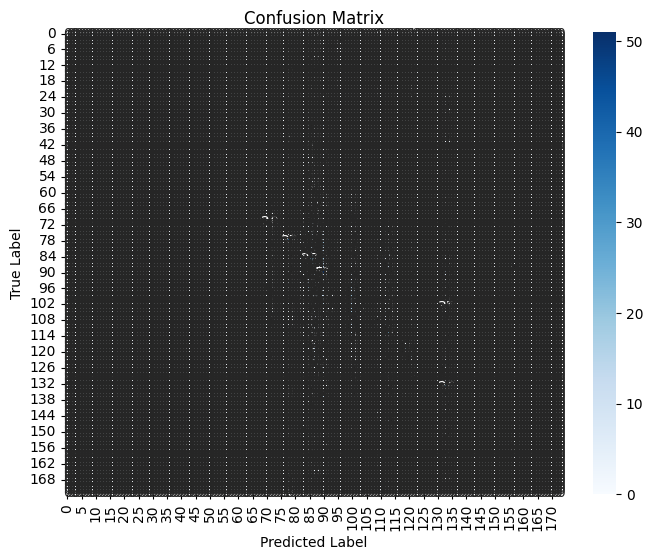

In [46]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Split the dataset for training and testing
X_train, X_test, y_train, y_test = train_test_split(features, y, test_size=0.3, random_state=42)

# Train an SVM model
svm_model = SVC(kernel='rbf')
svm_model.fit(X_train, y_train)

# Make predictions and evaluate the model
y_pred = svm_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


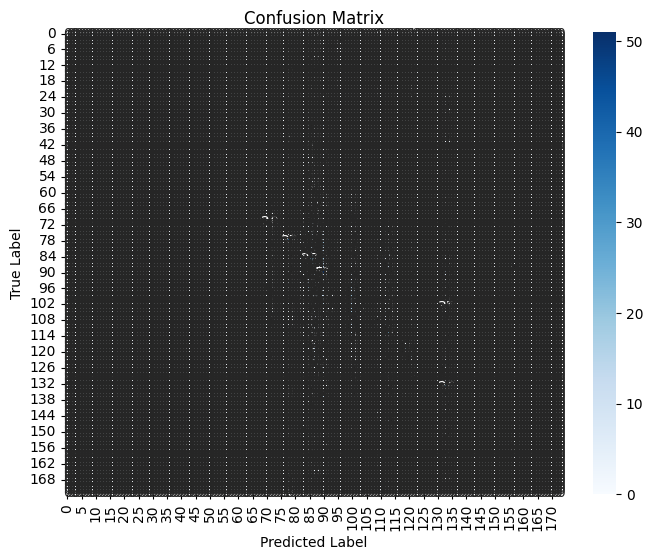

In [47]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

y_pred = svm_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


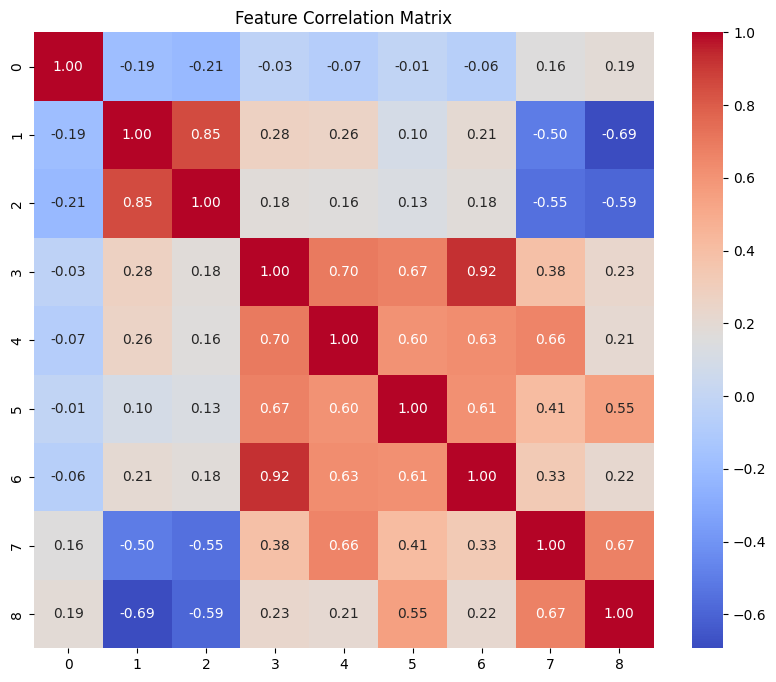

In [48]:
correlation_matrix = pd.DataFrame(features).corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Matrix")
plt.show()
